In [ ]:
import random as rd
import os
import math
import statistics
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from numpy.random import choice
from numpy.random import uniform
from numpy.random import normal
from numpy.random import randint
from numpy.random import permutation
from numpy import corrcoef
from numpy import flip
from numpy import around
from numpy import array as nparray
from numpy import arange as arange
from random import choices as rdchoices
from random import uniform as rduniform
import numba as nb
import time
import scipy.stats
from scipy.stats import multivariate_normal as mvn
from sklearn.utils import shuffle
import statistics
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp
from collections import Counter
from progress.bar import Bar
from scipy.stats import skewnorm
#import pandas as pd
from itertools import chain
import cProfile, pstats
from tqdm import tqdm
import seaborn as sns

In [2]:
class femaleSimulateIBI:
    
    def __init__(self, f):
        
        self.ID = f
        self.cycling, self.cycleDay = False, False
        self.nonCyclingPeriodInDays = round(normal(meanNonCyclingPeriodInDays, sdNonCyclingPeriodInDays))
        self.daysUntilCycling = randint(self.nonCyclingPeriodInDays * (1 - seasonality)+1)
        self.conceptionProbability, myConceptionProbabilityList = 0, []
        self.daysUntilConception = False
        self.myConceptionProbabilityList = []
        
    def switchToCycling(self):
            
        self.cycleDay = 0
        self.cycling = True
        self.daysUntilConception = round(normal(meanDaysToConception, sdDaysToConception))
        self.conceptionProbability = conceptionProbabilityList[0]
        
            
    def switchToNonCycling(self):
        
        self.cycleDay = False
        self.cycling = False
        self.daysUntilCycling = round(normal(meanNonCyclingPeriodInDays, sdNonCyclingPeriodInDays))
        self.conceptionProbability = 0
        

In [3]:
class groupOfFemales:
    
    def __init__(self):

        self.listOfFemales = [femaleSimulateIBI(f) for f in rangeFemales]

    def go(self):
        
        for r in range(modelDays):

            for f in [item for item in g.listOfFemales if item.cycling == True]:
                f.cycleDay = f.cycleDay + 1 if f.cycleDay < cycleLength - 1 else 0
                f.conceptionProbability = conceptionProbabilityList[f.cycleDay]
                f.switchToNonCycling() if f.cycling and f.daysUntilConception == 0 else 0
                f.daysUntilConception -= 1
                f.myConceptionProbabilityList += [f.conceptionProbability]
                
            for f in [item for item in g.listOfFemales if item.cycling == False]:
                f.switchToCycling() if not f.cycling and f.daysUntilCycling == 0 else 0
                f.daysUntilCycling -= 1
                f.myConceptionProbabilityList += [0]
            
            
                    

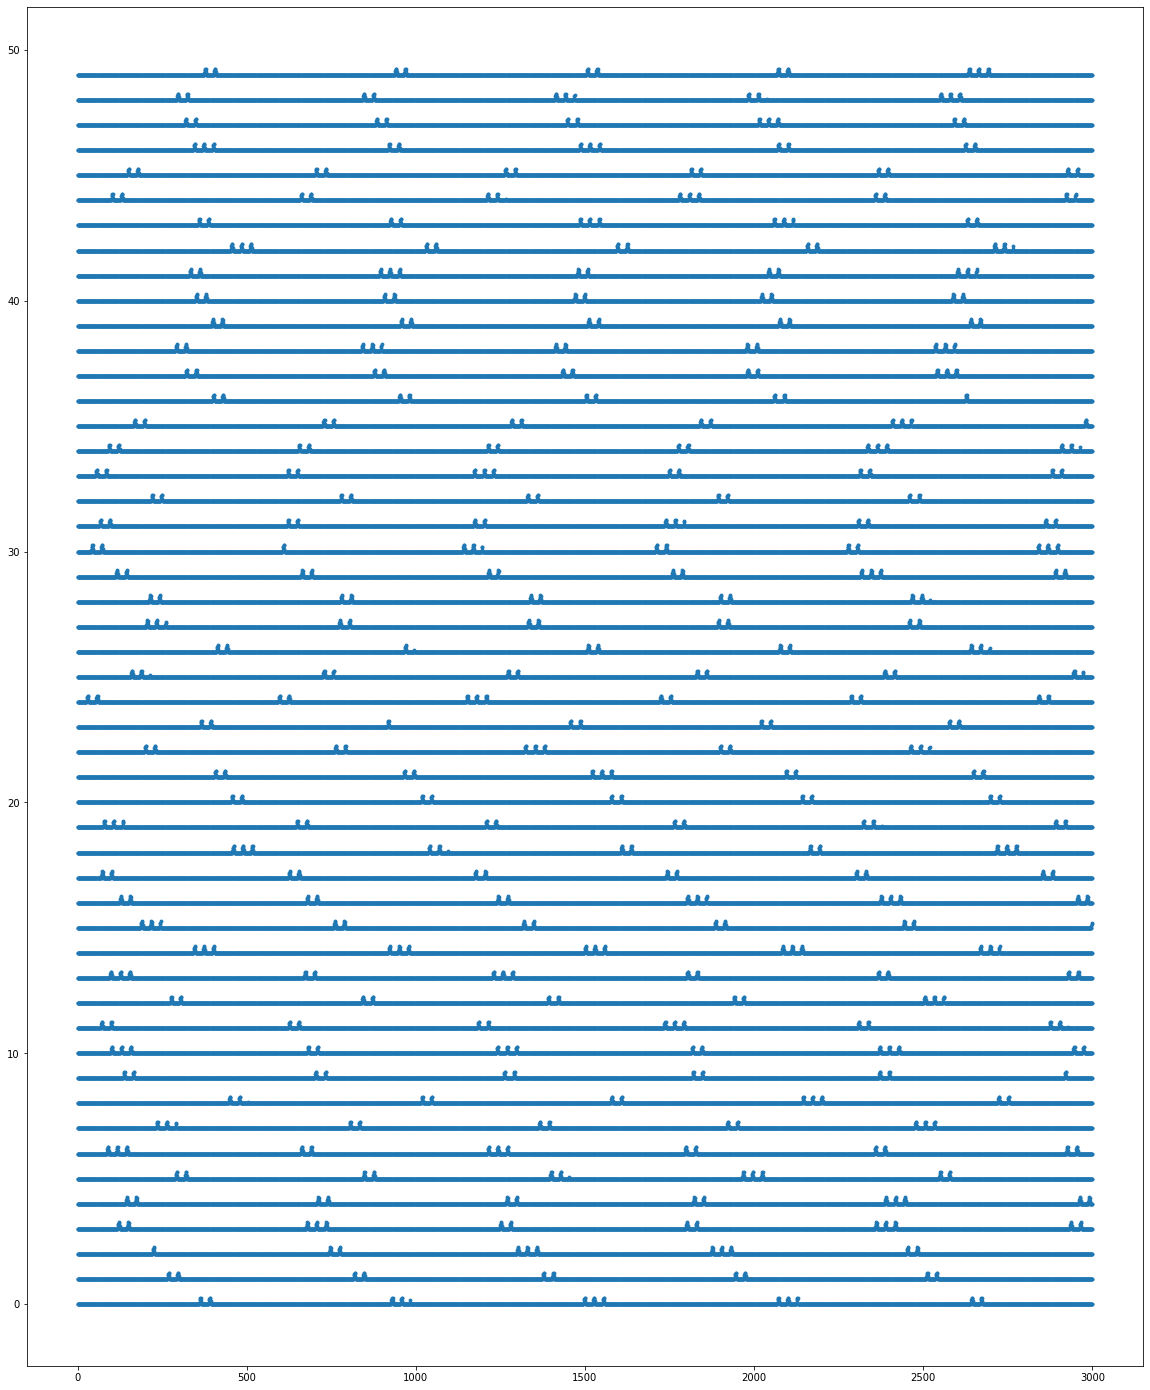

In [86]:
nFemales = 50
seasonality = 0.1

meanDaysToConception = 60
sdDaysToConception = 10

meanNonCyclingPeriodInDays = 500
sdNonCyclingPeriodInDays = 0

rangeFemales = range(nFemales)
cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post


modelDays = 3000
g = groupOfFemales()
g.go()
plt.figure(figsize=(20, nFemales / 2))
allDays = plt.scatter([range(modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                    for i in range(modelDays)]
                                   for f in g.listOfFemales], s=8)



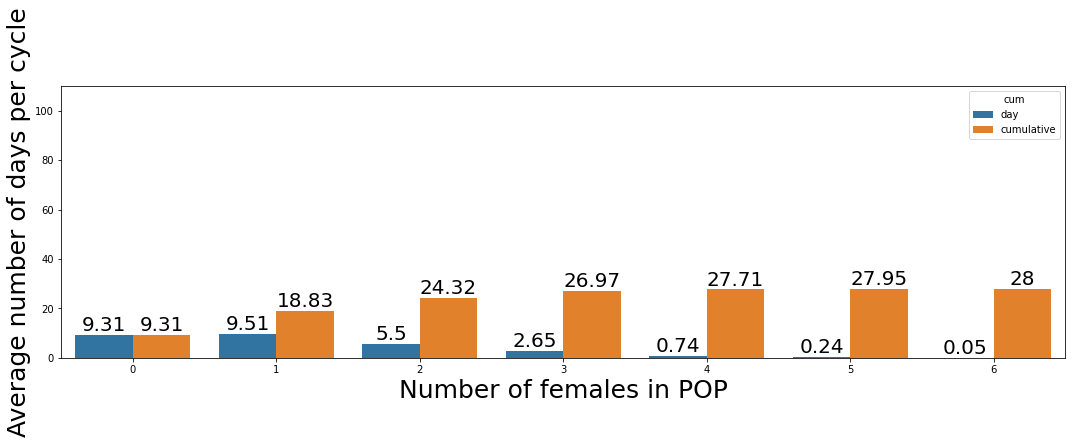

In [163]:
groupConceptionProbabilities = []

for d in range(modelDays):
    groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1 for f in g.listOfFemales])]
    
fertilePerDay = [groupConceptionProbabilities.count(i) / modelDays for i in range(nFemales + 1)]
fertilePerDay = [item for item in fertilePerDay if item > 0]

t = 0
for i in range(len(fertilePerDay)):
    t += (groupConceptionProbabilities.count(i) / modelDays)
    fertilePerDay += [t]
    

d = pd.DataFrame([[round(f*cycleLength,2) for f in fertilePerDay],
                  [f for f in range(round(len(fertilePerDay)/2))]*2,
                  ["day" for f in range(round(len(fertilePerDay)/2))] +
                  ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                 index=["numberFertile", "day", "cum"]).T

plt.figure(figsize=(18, 5))
fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'cum')

plt.bar_label(fertilePerDayPlot.containers[0], size = 20)
plt.bar_label(fertilePerDayPlot.containers[1], size = 20)
xlabel = plt.xlabel('Number of females in POP', size=25)
ylabel = plt.ylabel('Average number of days per cycle', size=25)
ylim = plt.ylim([0,110])

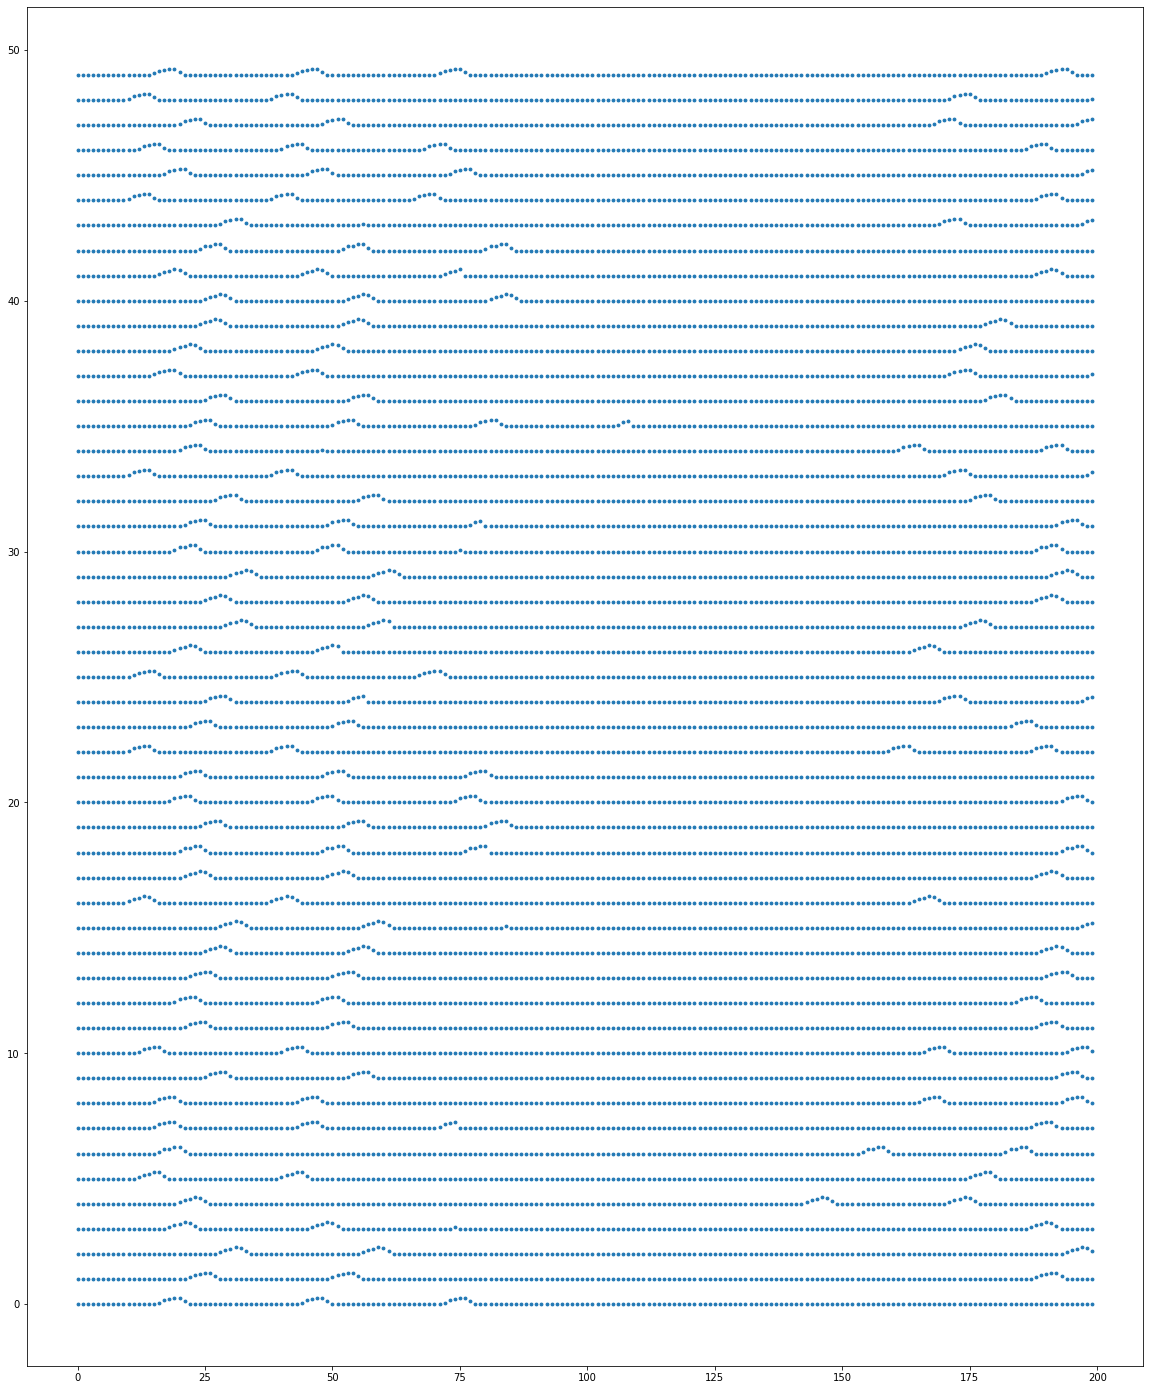

In [185]:
nFemales = 50
seasonality = 0.8

meanDaysToConception = 60
sdDaysToConception = 15

meanNonCyclingPeriodInDays = 101
sdNonCyclingPeriodInDays = 0

rangeFemales = range(nFemales)
cycleLength = 28

ovulation = 16
pre = ovulation - 6
post = cycleLength - pre - 6
conceptionProbabilityList = [0] * pre + [.05784435,.16082819,.19820558,.25408223,.24362408,.10373275] + [0] * post


modelDays = 200
g = groupOfFemales()
g.go()
plt.figure(figsize=(20, nFemales / 2))
allDays = plt.scatter([range(modelDays)] * nFemales, [[f.myConceptionProbabilityList[i] + f.ID
                                    for i in range(modelDays)]
                                   for f in g.listOfFemales], s=8)


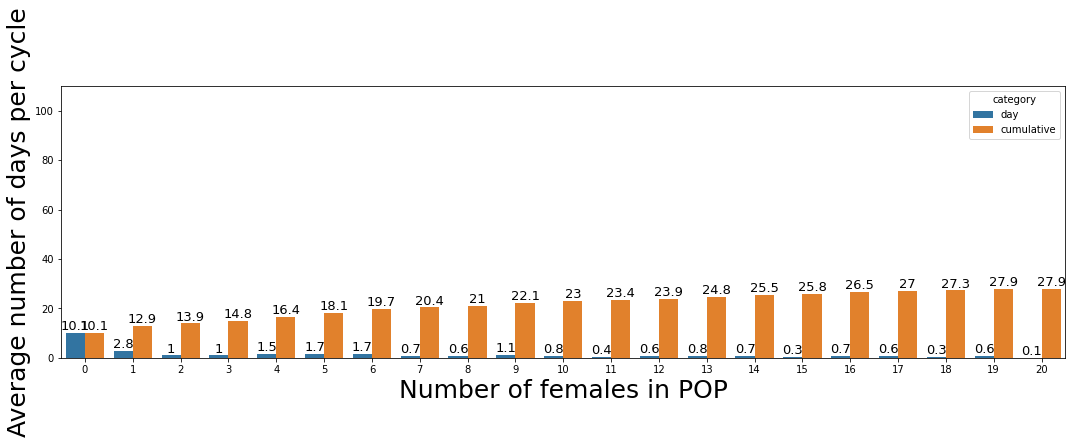

In [186]:
groupConceptionProbabilities = []

for d in range(modelDays):
    groupConceptionProbabilities += [sum([0 if f.myConceptionProbabilityList[d] == False else 1 for f in g.listOfFemales])]
    
fertilePerDay = [groupConceptionProbabilities.count(i) / modelDays for i in range(nFemales + 1)]
fertilePerDay = [item for item in fertilePerDay if item > 0]

t = 0
for i in range(len(fertilePerDay)):
    t += (groupConceptionProbabilities.count(i) / modelDays)
    fertilePerDay += [t]
    

d = pd.DataFrame([[round(f*cycleLength,1) for f in fertilePerDay],
                  [f for f in range(round(len(fertilePerDay)/2))]*2,
                  ["day" for f in range(round(len(fertilePerDay)/2))] +
                  ["cumulative" for f in range(round(len(fertilePerDay)/2))]],
                 index=["numberFertile", "day", "category"]).T

plt.figure(figsize=(18, 5))
fertilePerDayPlot = sns.barplot("day", "numberFertile", data = d, hue = 'category')

plt.bar_label(fertilePerDayPlot.containers[0], size = 13)
plt.bar_label(fertilePerDayPlot.containers[1], size = 13)
xlabel = plt.xlabel('Number of females in POP', size=25)
ylabel = plt.ylabel('Average number of days per cycle', size=25)
ylim = plt.ylim([0,110])